# Gaussain Processes From Scratch

## Intuitions
We are given samples from an unknown process. A process is the underlying mechanism that generates a measured signal.

GPs provide a way to regress these points (fit a curve) and provide uncertainty/confidence estimates throughout the domain of the regressed curve.

**At a high level, GPs are a distribution over functions.**

Technically, GPs are the infinite dimensional generalization of the multi-variate Gaussian distribution.

A function can be represented as a infinite dimensional vector. Then a GP can be interpreted as a distribution over infinite dimensional vectors. 

For practical purposes, we use the finite dimensional representation -- which is still jointly Gaussian.

## Math
$f$ ~ $GP(m, k)$

where $m$ is a mean fn. Denotes the a priori expectation of the unknown process. Typically set at 0.

$m(x) = E[f(x)]$

$K$ is the covariance or kernel fn. Measures how 'similar' or 'related' $f(x)$ and $f(x')$ are.

Must be a symmetric fn, i.e. $K(x, x') = K(x', x)$. Typically a Gaussian Kernel, aka square exponential, RBF.

$K(x, x') = exp(-\frac{||x-x'||^2}{2\sigma^2})$

Use the kernel function to form the covariance matrix.

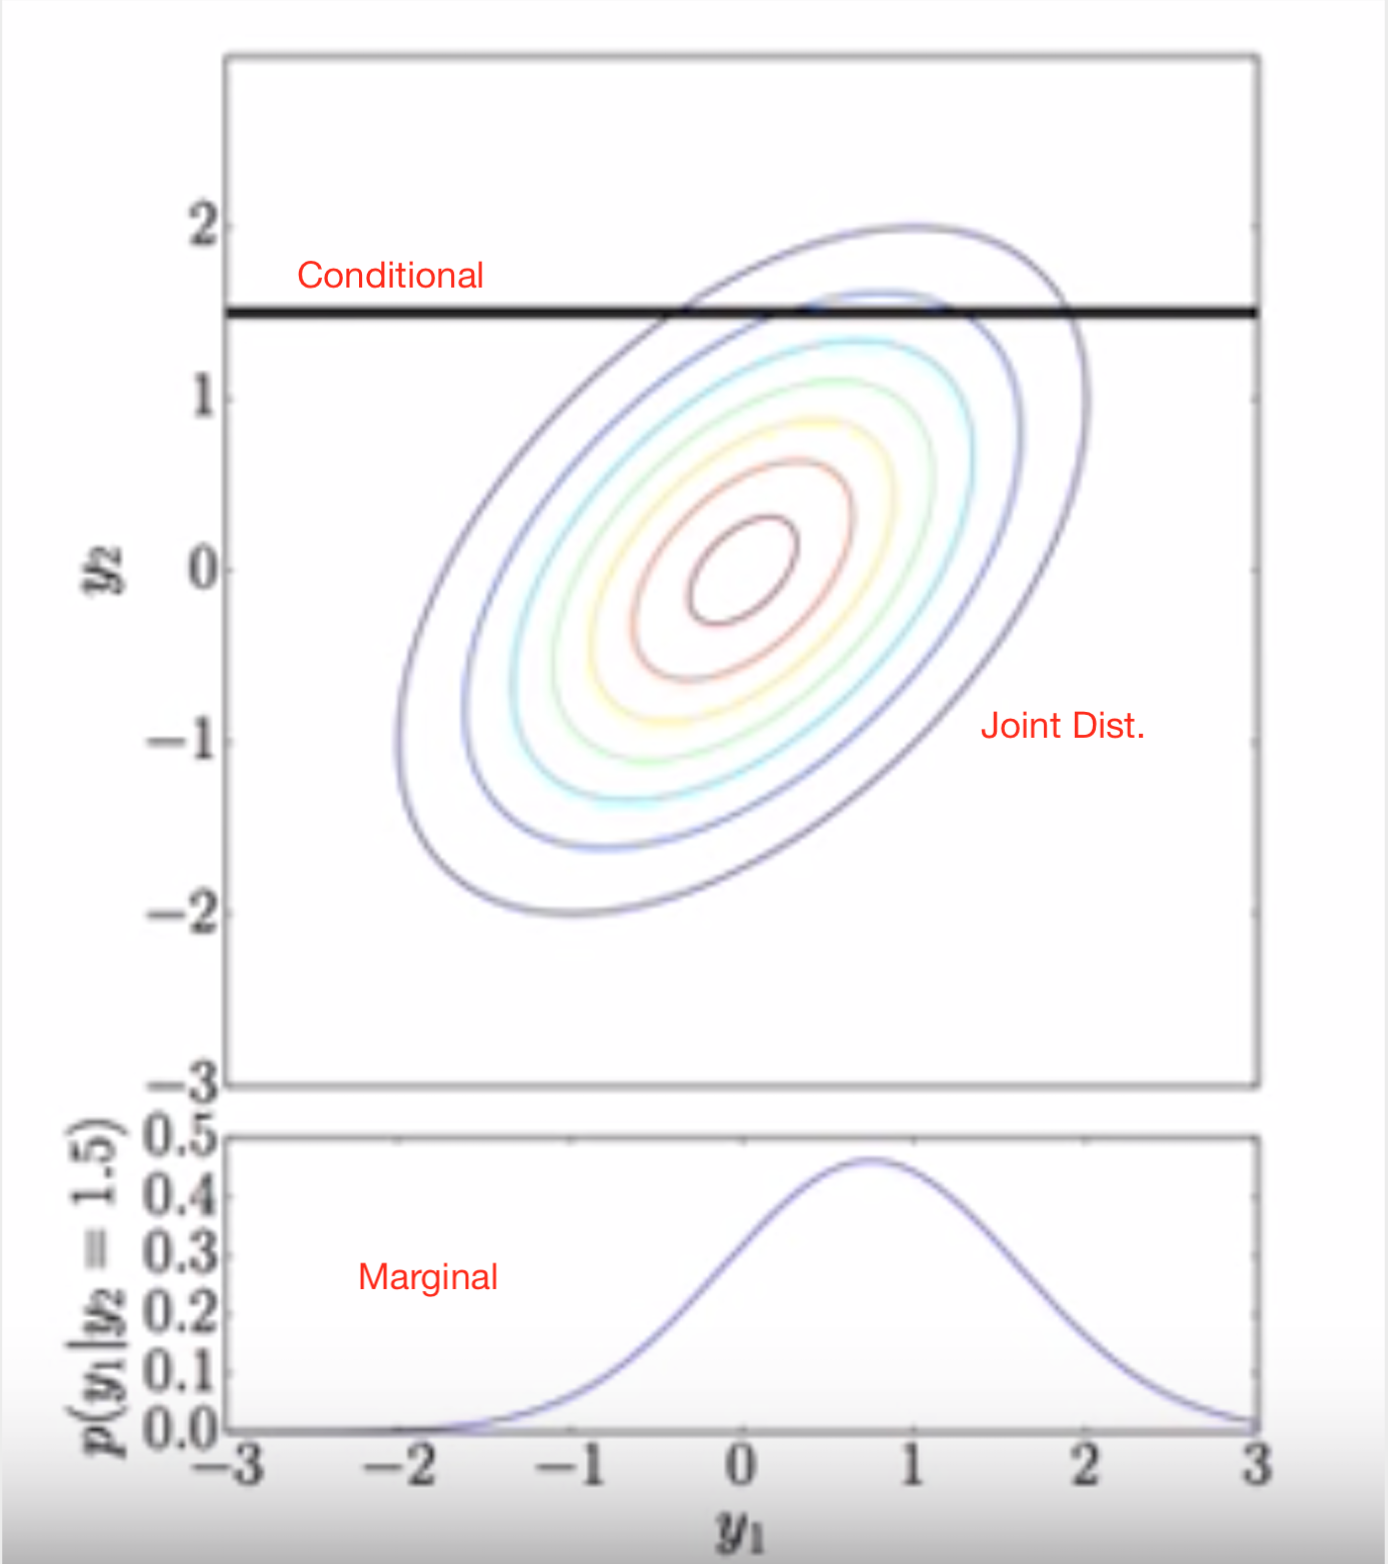
(from https://www.youtube.com/watch?v=rTZPfF8PoIs&list=PLR6O_WZHBlOGlq9GiYjCZb4nQbqsT11Pl&index=2)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Generate dataset with noise

Will take the form of $f(x) = x^3 + nosie$

In [50]:
def f(x, noise=True):
    return np.abs(x**3) + (np.random.normal() * x * 10 if noise else 0)

x_train = np.arange(-10, 10, 0.5)
y_train = np.array([f(i) for i in x])
y_ideal = np.array([f(i, noise=False) for i in x])
list(zip(x_train, y_train))

[(-10.0, 1044.4658365908954),
 (-9.5, 999.0773559492824),
 (-9.0, 598.1498092852538),
 (-8.5, 561.2982813665071),
 (-8.0, 510.33382742338597),
 (-7.5, 453.9202304717424),
 (-7.0, 443.30771653228584),
 (-6.5, 244.18826995892488),
 (-6.0, 266.4849955140136),
 (-5.5, 77.16031981390208),
 (-5.0, 61.02691080223367),
 (-4.5, 55.59589004634141),
 (-4.0, 102.5332952113659),
 (-3.5, 99.95619953935733),
 (-3.0, 41.268759398412534),
 (-2.5, 37.353462088940546),
 (-2.0, 2.4618666582543547),
 (-1.5, -2.4587542041827195),
 (-1.0, 3.698692787476513),
 (-0.5, 6.509320740177634),
 (0.0, 0.0),
 (0.5, -4.29610147459479),
 (1.0, -8.535157165809887),
 (1.5, -1.2969807287707313),
 (2.0, 32.128074761339434),
 (2.5, -14.270074753898818),
 (3.0, 23.956203067423797),
 (3.5, -3.2044078687653723),
 (4.0, 46.63862384612001),
 (4.5, -1.7739142211831478),
 (5.0, 192.8818120196485),
 (5.5, 148.63107757726308),
 (6.0, 194.32716767851338),
 (6.5, 307.6423157265182),
 (7.0, 366.62654902071785),
 (7.5, 380.65824491031765

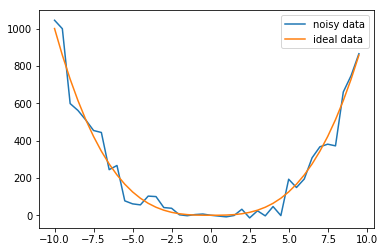

In [51]:
plt.plot(x_train, y_train, label='noisy data')
plt.plot(x_train, y_ideal, label='ideal data')
plt.legend()

## Sampling from a multi-variate Gaussian

Take $D$ samples from $N(0,1)$ to form the vector $v$

In [4]:
def draw_std_norm_samples(d):
    return np.array([np.random.normal() for i in range(d)])

D = 10
v = draw_std_norm_samples(D)
v

array([ 0.66984673, -0.48654664, -1.22263526,  0.53177438, -0.08543864,
        2.00768252, -0.48045292,  1.04059002,  0.9006386 ,  1.40846766])

(array([1., 0., 2., 1., 0., 2., 1., 1., 1., 1.]),
 array([-1.22263526, -0.89960348, -0.5765717 , -0.25353992,  0.06949186,
         0.39252363,  0.71555541,  1.03858719,  1.36161897,  1.68465075,
         2.00768252]),
 <a list of 10 Patch objects>)

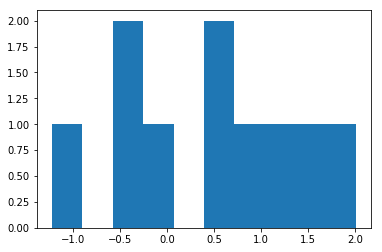

In [5]:
plt.hist(v)

Generate a covariance matrix $\Sigma$ of shape D x D

In [6]:
Cov = np.eye(D, dtype=np.int) * 3
for i in range(1, D):
    Cov[i-1, i] = 1
for i in range(D-1):
    Cov[i+1, i] = 1
Cov

array([[3, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 3, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 3, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 3, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 3, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 3, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 3, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 3, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 3, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 3]])

Cholesky Decomposition of $\Sigma$

In [7]:
np.linalg.eigvalsh(Cov)

array([1.08101405, 1.31749293, 1.69027853, 2.16916997, 2.71537032,
       3.28462968, 3.83083003, 4.30972147, 4.68250707, 4.91898595])

In [8]:
L = np.linalg.cholesky(Cov)
assert np.allclose(L @ L.transpose(), Cov)
L

array([[1.73205081, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.57735027, 1.63299316, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.61237244, 1.62018517, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.6172134 , 1.61834719, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.61791438, 1.61807967,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.61801654,
        1.61804065, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.61803144, 1.61803496, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

$y = \mu + L * v$

$y$ ~ $N(\mu, \Sigma)$

In [9]:
L.shape, v.shape

((10, 10), (10,))

In [10]:
u = np.zeros(D, dtype=np.int)
y = u + L @ v
y

array([ 1.16020857, -0.40779115, -2.27884327,  0.10596871,  0.19034451,
        3.19570945,  0.46342131,  1.38677411,  2.10038383,  2.8355738 ])

In [11]:
def draw_sample_from_parameterized_mvn_dist(mu, sigma):
    assert sigma.shape[0] == sigma.shape[1]
    d = sigma.shape[0]
    v = draw_std_norm_samples(d)
    L = np.linalg.cholesky(sigma)
    return mu + L @ v

In [12]:
draw_sample_from_parameterized_mvn_dist(u, Cov)

array([-1.88039151, -1.53638973, -0.89123435, -1.57296022, -0.40160736,
       -0.8216869 ,  2.32414472, -0.87555197, -0.36027173, -2.65269329])

# Fitting a GP

1. Choose a kernel function $K(.)$.
2. Form the covariance matrix $\Sigma$ by computing K() for each entry. $\Sigma$ will be symmetric.
3. Normalize the data by subtracting the mean. Retain the original data mean as $\mu$.

Gaussian Kernel:
$K(x, x') = exp(-\frac{||x-x'||^2}{2\sigma^2})$

In [24]:
def gaussian_kernel(x, x_, sigma=1):
    return np.exp(-1 * np.abs(x - x_) / (2*np.square(sigma)))

kernel = gaussian_kernel

def form_general_covariance_matrix(data1, data2, kernel_fn=kernel):
    d = d1 = data1.shape[0]
    d2 = data2.shape[0]
    assert d1 == d2
    cov = np.zeros((d, d))
    for row in range(d):
        for col in range(d):
            cov[row, col] = kernel_fn(data1[row], data2[col])
    return cov

def form_covariance_matrix(data, kernel_fn=kernel):
    """ Forms a covariance matrix, shape=(d,d), where d = elements in data.
    Each entry is formed by evaluating kernel_fn()
    """
    return form_general_covariance_matrix(data, data, kernel_fn=kernel)

sigma2 = form_general_covariance_matrix(y, y)

sigma = form_covariance_matrix(y)
assert sigma.shape == (D, D)
assert np.allclose(sigma2, sigma)
sigma.shape, sigma

((10, 10), array([[1.        , 0.87257284, 0.64064424, 0.57589623, 0.75590998,
         0.52149452, 0.96186489, 0.9111286 , 0.52115793, 0.77669556],
        [0.87257284, 1.        , 0.73420145, 0.65999788, 0.86630015,
         0.59765157, 0.83929718, 0.95768352, 0.59726582, 0.89012117],
        [0.64064424, 0.73420145, 1.        , 0.89893296, 0.84751394,
         0.81401578, 0.61621321, 0.70313263, 0.81349038, 0.82483315],
        [0.57589623, 0.65999788, 0.89893296, 1.        , 0.76185821,
         0.90553558, 0.55393436, 0.6320691 , 0.90495111, 0.74146971],
        [0.75590998, 0.86630015, 0.84751394, 0.76185821, 1.        ,
         0.68988972, 0.72708327, 0.82964137, 0.68944444, 0.97323845],
        [0.52149452, 0.59765157, 0.81401578, 0.90553558, 0.68988972,
         1.        , 0.50160727, 0.57236105, 0.99935456, 0.6714272 ],
        [0.96186489, 0.83929718, 0.61621321, 0.55393436, 0.72708327,
         0.50160727, 1.        , 0.87638261, 0.50128352, 0.74707619],
        [0.911128

## Sampling from a GP (prior)

### Steps
1. Fit the GP to some given data, resulting in the covariance matrix $\Sigma$.
2. Do the Cholesky decomposition: $\Sigma = L * L'$
3. Discretize the domain into a D dim vector.
4. Form $v$ by drawing D samples from N(0, 1).
5. Compute the mean vector $\mu$ for all points in $v$
6. Compute $y = \mu + L*v$

$y$ is now a Dx1 vector of points representing **a single function sample, sampled from the GP.**

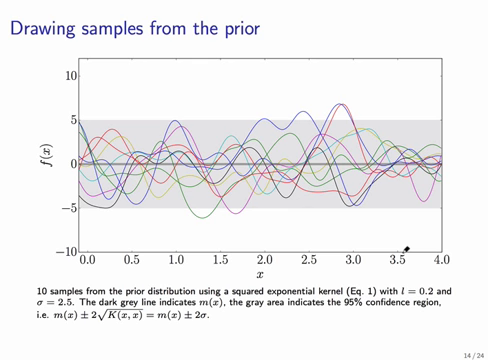

In [15]:
def draw_sample_from_GP_prior(sigma, mu=None):
    D = sigma.shape[0]
    L = np.linalg.cholesky(sigma)
    v = draw_std_norm_samples(D)
    mu_vector = mu if mu is not None else np.zeros(D)
    y = mu_vector + L @ v
    return y

In [16]:
# sigma already computed
y = draw_sample_from_GP_prior(sigma)
y

array([-1.22420042, -0.95158212, -0.33363846, -0.12054482, -0.66453445,
        0.0779126 , -1.30196298, -1.03805795,  0.07920389, -0.71878677])

Draw 15 samples from the prior:

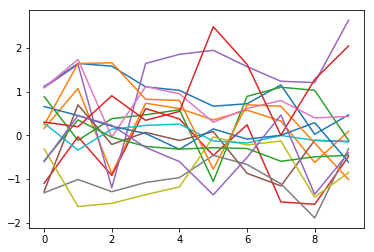

In [17]:
samples = [draw_sample_from_GP_prior(sigma) for i in range(15)]
for sample in samples:
    plt.plot(sample)

## Sampling from a GP noise free (inference)

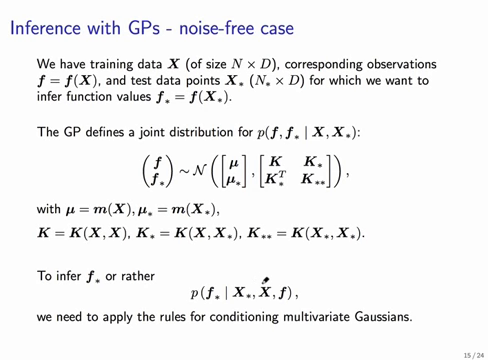

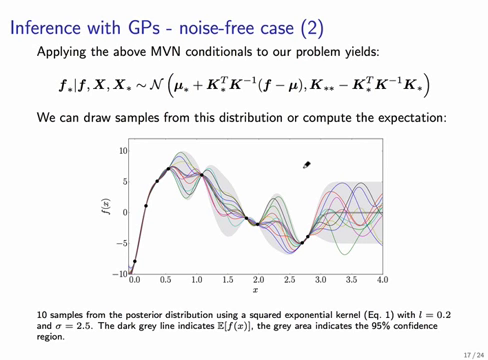

In [101]:
N_ = 40

In [102]:
X_ = np.arange(-1*N_/2 + 5.5, N_/2 + 5.5) / 2
assert X_.shape == (N_,)
X_.shape, X_

((40,), array([-7.25, -6.75, -6.25, -5.75, -5.25, -4.75, -4.25, -3.75, -3.25,
        -2.75, -2.25, -1.75, -1.25, -0.75, -0.25,  0.25,  0.75,  1.25,
         1.75,  2.25,  2.75,  3.25,  3.75,  4.25,  4.75,  5.25,  5.75,
         6.25,  6.75,  7.25,  7.75,  8.25,  8.75,  9.25,  9.75, 10.25,
        10.75, 11.25, 11.75, 12.25]))

Construct $\mu_*$ vector

In [103]:
u_ = np.zeros(N_)

Construct covariance matrix $K$, $K_*$, and $K_{**}$

In [104]:
K = form_general_covariance_matrix(x_train, x_train)

In [105]:
K_ = form_general_covariance_matrix(x_train, X_)
alt_K_ = form_general_covariance_matrix(X_, x_train)
assert np.allclose(K_.transpose(), alt_K_)
K_.shape, K_

((40, 40), array([[2.52839596e-01, 1.96911675e-01, 1.53354967e-01, ...,
         2.43008313e-05, 1.89255064e-05, 1.47391992e-05],
        [3.24652467e-01, 2.52839596e-01, 1.96911675e-01, ...,
         3.12028850e-05, 2.43008313e-05, 1.89255064e-05],
        [4.16862020e-01, 3.24652467e-01, 2.52839596e-01, ...,
         4.00652974e-05, 3.12028850e-05, 2.43008313e-05],
        ...,
        [3.80128958e-04, 4.88095244e-04, 6.26726698e-04, ...,
         2.52839596e-01, 1.96911675e-01, 1.53354967e-01],
        [2.96044730e-04, 3.80128958e-04, 4.88095244e-04, ...,
         3.24652467e-01, 2.52839596e-01, 1.96911675e-01],
        [2.30559868e-04, 2.96044730e-04, 3.80128958e-04, ...,
         4.16862020e-01, 3.24652467e-01, 2.52839596e-01]]))

In [106]:
K__ = form_covariance_matrix(X_)
K__.shape, K__

((40, 40), array([[1.00000000e+00, 7.78800783e-01, 6.06530660e-01, ...,
         9.61116521e-05, 7.48518299e-05, 5.82946637e-05],
        [7.78800783e-01, 1.00000000e+00, 7.78800783e-01, ...,
         1.23409804e-04, 9.61116521e-05, 7.48518299e-05],
        [6.06530660e-01, 7.78800783e-01, 1.00000000e+00, ...,
         1.58461325e-04, 1.23409804e-04, 9.61116521e-05],
        ...,
        [9.61116521e-05, 1.23409804e-04, 1.58461325e-04, ...,
         1.00000000e+00, 7.78800783e-01, 6.06530660e-01],
        [7.48518299e-05, 9.61116521e-05, 1.23409804e-04, ...,
         7.78800783e-01, 1.00000000e+00, 7.78800783e-01],
        [5.82946637e-05, 7.48518299e-05, 9.61116521e-05, ...,
         6.06530660e-01, 7.78800783e-01, 1.00000000e+00]]))

Construct parameters to the normal distribution

In [107]:
K_block = np.block([[K, K_], [K_.transpose(), K__]])

In [108]:
mu_param = u_ + K_.transpose() @ np.linalg.inv(K) @ (y_train - u_)
print(mu_param.shape, mu_param)
sigma_param = K__ - K_.transpose() @ np.linalg.inv(K) @ K_
sigma_param.shape, sigma_param

(40,) [ 4.45131850e+02  3.41079836e+02  2.53354720e+02  1.70488977e+02
  6.85573135e+01  5.78587898e+01  7.84508965e+01  1.00458890e+02
  7.00643883e+01  3.90059795e+01  1.97531419e+01  1.54414767e-03
  6.15157116e-01  5.06438968e+00  3.22939783e+00 -2.13137766e+00
 -6.36583147e+00 -4.87791062e+00  1.52958922e+01  8.85969348e+00
  4.80547249e+00  1.02953603e+01  2.15485407e+01  2.22582358e+01
  9.48122631e+01  1.69431040e+02  1.70148109e+02  2.49036609e+02
  3.34517609e+02  3.70742200e+02  3.73250761e+02  5.11971314e+02
  6.98644493e+02  8.00239722e+02  7.63403623e+02  5.94539339e+02
  4.63027703e+02  3.60606338e+02  2.80840498e+02  2.18718800e+02]


((40, 40), array([[ 1.24353002e-01, -1.11022302e-16,  0.00000000e+00, ...,
          4.06575815e-20,  4.06575815e-20,  1.35525272e-20],
        [ 0.00000000e+00,  1.24353002e-01, -1.11022302e-16, ...,
         -1.08420217e-19, -9.48676901e-20, -5.42101086e-20],
        [-2.22044605e-16, -3.33066907e-16,  1.24353002e-01, ...,
         -1.08420217e-19, -8.13151629e-20, -8.13151629e-20],
        ...,
        [-9.48676901e-20, -1.08420217e-19, -1.62630326e-19, ...,
          8.26226057e-01,  6.43465500e-01,  5.01131435e-01],
        [-6.77626358e-20, -1.08420217e-19, -1.35525272e-19, ...,
          6.43465500e-01,  8.94600775e-01,  6.96715784e-01],
        [-6.09863722e-20, -6.77626358e-20, -1.08420217e-19, ...,
          5.01131435e-01,  6.96715784e-01,  9.36072139e-01]]))

Sample from the distribution

In [109]:
np.linalg.eigvalsh(sigma_param)

array([0.124353  , 0.124353  , 0.124353  , 0.124353  , 0.124353  ,
       0.124353  , 0.124353  , 0.124353  , 0.124353  , 0.124353  ,
       0.124353  , 0.124353  , 0.124353  , 0.124353  , 0.124353  ,
       0.124353  , 0.124353  , 0.124353  , 0.124353  , 0.124353  ,
       0.124353  , 0.124353  , 0.124353  , 0.124353  , 0.124353  ,
       0.124353  , 0.124353  , 0.124353  , 0.124353  , 0.124353  ,
       0.124353  , 0.124353  , 0.124353  , 0.124353  , 0.12643043,
       0.14480608, 0.19353253, 0.31660891, 0.70679354, 2.63105535])

In [110]:
sample = np.random.multivariate_normal(mu_param, sigma_param)
sample.shape, sample

((40,),
 array([ 4.44457875e+02,  3.40778849e+02,  2.53040514e+02,  1.70655657e+02,
         6.86516913e+01,  5.81833340e+01,  7.81398054e+01,  1.00431979e+02,
         6.98897962e+01,  3.88725177e+01,  1.95557843e+01,  6.54775465e-01,
         7.76664291e-01,  4.82150189e+00,  3.14268390e+00, -2.40864046e+00,
        -6.94924451e+00, -4.35712722e+00,  1.48117082e+01,  8.66741926e+00,
         5.48086585e+00,  1.00576802e+01,  2.13156314e+01,  2.22356982e+01,
         9.47652854e+01,  1.69259396e+02,  1.70303206e+02,  2.48098906e+02,
         3.33979446e+02,  3.71051786e+02,  3.72983639e+02,  5.12088802e+02,
         6.98338601e+02,  8.00848681e+02,  7.63734267e+02,  5.95571925e+02,
         4.63593165e+02,  3.60656159e+02,  2.80838209e+02,  2.18808820e+02]))

Draw 15 samples from the posterior

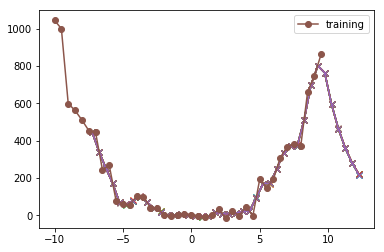

In [111]:
samples = [np.random.multivariate_normal(mu_param, sigma_param) for i in range(15)]
for sample in samples:
    plt.plot(X_, sample, marker='x')
plt.plot(x_train, y_train, label='training', marker='o')
plt.legend()

**TODO: add uncertainty bars. How??**

Strangely, the distribution 'falls off' during extrapolation. Why?

## Sampling from a GP w/ noise (inference)

In [ ]:
# TODO

# References
- [A great short video series on GPs](https://www.youtube.com/watch?v=9hKfsuoFdeQ&list=PLR6O_WZHBlOGlq9GiYjCZb4nQbqsT11Pl&index=1)